# Assignment 1 - DLT Implementation

In [1]:
# import necessary libraries
import numpy as np

In [39]:
def Normalization(nd, x):
    '''
    Normalization of coordinates (centroid to the origin and mean distance of sqrt(2 or 3).
    Input
    -----
    nd: number of dimensions, 3 here
    x: the data to be normalized (directions at different columns and points at rows)
    Output
    ------
    Tr: the transformation matrix (translation plus scaling)
    x: the transformed data
    '''

    x = np.asarray(x)
    m, s = np.mean(x, 0), np.std(x)
    if nd == 2:
        Tr = np.array([[s, 0, m[0]], [0, s, m[1]], [0, 0, 1]])
    else:
        Tr = np.array([[s, 0, 0, m[0]], [0, s, 0, m[1]], [0, 0, s, m[2]], [0, 0, 0, 1]])
        
    Tr = np.linalg.inv(Tr)
    x = np.dot( Tr, np.concatenate( (x.T, np.ones((1,x.shape[0]))) ) )
    x = x[0:nd, :].T

    return Tr, x


def DLTcalibration(nd, xyz, uv, Norm_flg):
    '''
    Camera calibration by DLT using known object points and their image points.
    Input
    -----
    nd: dimensions of the object space, 3 here.
    xyz: coordinates in the object 3D space.
    uv: coordinates in the image 2D space.
    The coordinates (x,y,z and u,v) are given as columns and the different points as rows.
    There must be at least 6 calibration points for the 3D DLT.
    Output
    ------
     L: array of 11 parameters of the calibration matrix.
     err: error of the DLT (mean residual of the DLT transformation in units of camera coordinates).
    '''
    if (nd != 3):
        raise ValueError('%dD DLT unsupported.' %(nd))
    
    # Converting all variables to numpy array
    xyz = np.asarray(xyz)
    uv = np.asarray(uv)

    n = xyz.shape[0]
     
    
    # Validating the parameters:
    if uv.shape[0] != n:
        raise ValueError('Object (%d points) and image (%d points) have different number of points.' %(n, uv.shape[0]))

    if (xyz.shape[1] != 3):
        raise ValueError('Incorrect number of coordinates (%d) for %dD DLT (it should be %d).' %(xyz.shape[1],nd,nd))

    if (n < 6):
        raise ValueError('%dD DLT requires at least %d calibration points. Only %d points were entered.' %(nd, 2*nd, n))
    
    if Norm_flg:
    # Normalize the data to improve the DLT quality (DLT is dependent of the system of coordinates).
    # This is relevant when there is a considerable perspective distortion.
    # Normalization: mean position at origin and mean distance equals to 1 at each direction.
   
        Txyz, xyzn = Normalization(nd, xyz)
        Tuv, uvn = Normalization(2, uv)
           

    A = []

    for i in range(n):
        if Norm_flg:
            x, y, z = xyzn[i, 0], xyzn[i, 1], xyzn[i, 2]
            u, v = uvn[i, 0], uvn[i, 1]
        else:
            x, y, z = xyz[i, 0], xyz[i, 1], xyz[i, 2]
            u, v = uv[i, 0], uv[i, 1]
        A.append( [x, y, z, 1, 0, 0, 0, 0, -u * x, -u * y, -u * z, -u] )
        A.append( [0, 0, 0, 0, x, y, z, 1, -v * x, -v * y, -v * z, -v] )

    # Convert A to array
    A = np.asarray(A) 

    # Find the 11 parameters:
    U, S, V = np.linalg.svd(A)

    # The parameters are in the last line of Vh and normalize them
    L = V[-1, :] / V[-1, -1]
    print(L)
    # Camera projection matrix
    H = L.reshape(3, nd + 1)
    print(H)

    # Denormalization
    # pinv: Moore-Penrose pseudo-inverse of a matrix, generalized inverse of a matrix using its SVD
    if Norm_flg:
        H = np.dot( np.dot( np.linalg.pinv(Tuv), H ), Txyz )
 #   else:
  #      H = np.dot( np.dot( np.linalg.pinv(uv), H ), xyz )
    print(H)
    H = H / H[-1, -1]
    print(H)
    L = H.flatten(order = 'C')
    print(L)

    # Mean error of the DLT (mean residual of the DLT transformation in units of camera coordinates):
    uv2 = np.dot( H, np.concatenate( (xyz.T, np.ones((1, xyz.shape[0]))) ) ) 
    uv2 = uv2 / uv2[2, :] 
    # reconstruction matrix
    R = uv2[0:2, :].T
    # Mean distance:
    err = np.sqrt( np.mean(np.sum( (uv2[0:2, :].T - uv)**2, 1)) ) 
    
    return L, R, err



# (a) Scale of each chessblock = 28x28mm

In [56]:

# (a) Scale of each chessblock = 28x28mm

# 3D World coordinates
xyz = [[28,0,28], [56,0,28],[84,0,28],[28,0,56],[0,28,28],[0,56,28],[0,84,28]]
# 2D Known pixel coordinates
uv = [[1665, 1784], [1794,1806], [1927,1831],[1663,1957], [1412,1782],[1278,1803],[1134,1823]]
nd = 3 # Dimensions

Normalization_flag = True
P, R, err = DLTcalibration(nd, xyz, uv, Normalization_flag)

print('Calibration Matrix using Normalized data points')
print(P)

print('Reconstruction using Normalized data points ')
print(R)

print('\nError')
print(err)
    

[ 1.23445352e-09  2.73154366e-09 -5.93928572e+01  1.66300000e+03
  2.91069837e-09 -7.69643705e-10 -6.98928572e+01  1.95700000e+03
  1.97273640e-12 -3.65546055e-13 -3.57142857e-02  1.00000000e+00]
[[ 1.23445352e-09  2.73154366e-09 -5.93928572e+01  1.66300000e+03]
 [ 2.91069837e-09 -7.69643705e-10 -6.98928572e+01  1.95700000e+03]
 [ 1.97273640e-12 -3.65546055e-13 -3.57142857e-02  1.00000000e+00]]
[[ 1.23445352e-09  2.73154366e-09 -5.93928572e+01  1.66300000e+03]
 [ 2.91069837e-09 -7.69643705e-10 -6.98928572e+01  1.95700000e+03]
 [ 1.97273640e-12 -3.65546055e-13 -3.57142857e-02  1.00000000e+00]]
[[ 1.23445352e-09  2.73154366e-09 -5.93928572e+01  1.66300000e+03]
 [ 2.91069837e-09 -7.69643705e-10 -6.98928572e+01  1.95700000e+03]
 [ 1.97273640e-12 -3.65546055e-13 -3.57142857e-02  1.00000000e+00]]
[ 1.23445352e-09  2.73154366e-09 -5.93928572e+01  1.66300000e+03
  2.91069837e-09 -7.69643705e-10 -6.98928572e+01  1.95700000e+03
  1.97273640e-12 -3.65546055e-13 -3.57142857e-02  1.00000000e+00]
Ca

# (b) Scale of each chessblock = 2800x2800mm

In [41]:
# (a) Scale of each chessblock = 2800x2800mm

# 3D World coordinates
xyz = [[2800,0,2800], [5600,0,2800],[8400,0,2800],[2800,0,5600],[0,2800,2800],[0,5600,2800],[0,8400,2800]]
# 2D Known pixel coordinates
uv = [[1665, 1784], [1794,1806], [1927,1831],[1663,1957], [1412,1782],[1278,1803],[1134,1823]]
nd = 3 # Dimensions

Normalization_flag = False
P, R, err = DLTcalibration(nd, xyz, uv, Normalization_flag)

print('Calibration Matrix using Original data points ')
print(P)

print('Reconstruction using Original data points ')
print(R)

print('\nError')
print(err)

Normalization_flag = True
P, R, err = DLTcalibration(nd, xyz, uv, Normalization_flag)

print('Calibration Matrix using Normalized data points')
print(P)

print('Reconstruction using Normalized data points ')
print(R)

print('\nError')
print(err)

[-2.79088908e-10  1.02554893e-09 -5.93928586e-01  1.66300000e+03
  5.34339929e-10 -4.22690976e-10 -6.98928590e-01  1.95700001e+03
  4.16157458e-13 -3.23407965e-13 -3.57142866e-04  1.00000000e+00]
[[-2.79088908e-10  1.02554893e-09 -5.93928586e-01  1.66300000e+03]
 [ 5.34339929e-10 -4.22690976e-10 -6.98928590e-01  1.95700001e+03]
 [ 4.16157458e-13 -3.23407965e-13 -3.57142866e-04  1.00000000e+00]]
[[-2.79088908e-10  1.02554893e-09 -5.93928586e-01  1.66300000e+03]
 [ 5.34339929e-10 -4.22690976e-10 -6.98928590e-01  1.95700001e+03]
 [ 4.16157458e-13 -3.23407965e-13 -3.57142866e-04  1.00000000e+00]]
[[-2.79088908e-10  1.02554893e-09 -5.93928586e-01  1.66300000e+03]
 [ 5.34339929e-10 -4.22690976e-10 -6.98928590e-01  1.95700001e+03]
 [ 4.16157458e-13 -3.23407965e-13 -3.57142866e-04  1.00000000e+00]]
[-2.79088908e-10  1.02554893e-09 -5.93928586e-01  1.66300000e+03
  5.34339929e-10 -4.22690976e-10 -6.98928590e-01  1.95700001e+03
  4.16157458e-13 -3.23407965e-13 -3.57142866e-04  1.00000000e+00]
Ca

# 2. Decompose the projection matrix

In [57]:
P

array([ 2.39397634e-14, -2.15003476e-14, -5.93928571e+01,  1.66300000e+03,
        7.60069741e-15, -1.12744855e-15, -6.98928571e+01,  1.95700000e+03,
        2.53962805e-18, -2.27372897e-18, -3.57142857e-02,  1.00000000e+00])

In [58]:
M = np.reshape(P, (-1, 4))
M

array([[ 2.39397634e-14, -2.15003476e-14, -5.93928571e+01,
         1.66300000e+03],
       [ 7.60069741e-15, -1.12744855e-15, -6.98928571e+01,
         1.95700000e+03],
       [ 2.53962805e-18, -2.27372897e-18, -3.57142857e-02,
         1.00000000e+00]])

In [59]:
#Find the QR decomposition of Camera matrix
K, R = np.linalg.qr(M)  
print('\nK:\n', K) 
print('\nR:\n', R) 


K:
 [[-9.53115392e-01  3.02607070e-01 -1.05687647e-04]
 [-3.02607071e-01 -9.53115397e-01 -1.24867193e-06]
 [-1.01110380e-04  3.07917008e-05  9.99999994e-01]]

R:
 [[-2.51173820e-14  2.08334864e-14  7.77583227e+01 -2.17723304e+03]
 [ 0.00000000e+00 -5.43156869e-15  4.86432587e+01 -1.36201124e+03]
 [ 0.00000000e+00  0.00000000e+00 -2.93499210e-02  8.21797787e-01]]


In [60]:
import matplotlib.pyplot as plt
def calculate_camera_center(M):
    """
    Returns the camera center matrix for a given projection matrix.
    The center of the camera C can be found by:
        C = -Q^(-1)m4
    where your project matrix M = (Q | m4).
    Args:
    -   M: A numpy array of shape (3, 4) representing the projection matrix
    Returns:
    -   cc: A numpy array of shape (1, 3) representing the camera center
            location in world coordinates
    """

    # Placeholder camera center. In the visualization, you will see this camera
    # location is clearly incorrect, placing it in the center of the room where
    # it would not see all of the points.

    ###########################################################################
    ###########################################################################
    Q=M[0:3,0:3]
    Qinv=np.linalg.inv(Q)
    cc=np.matmul(-Qinv,M[:,3])
    ###########################################################################
    ###########################################################################
    return cc
center = calculate_camera_center(M);
print('The estimated location of the camera is <{:.4f}, {:.4f}, {:.4f}>'.format(*center))

The estimated location of the camera is <64.0000, 128.0000, 28.0000>


In [61]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
def calculate_camera_center(M):
    """
    Returns the camera center matrix for a given projection matrix.
    The center of the camera C can be found by:
        C = -Q^(-1)m4
    where your project matrix M = (Q | m4).
    Args:
    -   M: A numpy array of shape (3, 4) representing the projection matrix
    Returns:
    -   cc: A numpy array of shape (1, 3) representing the camera center
            location in world coordinates
    """

    # Placeholder camera center. In the visualization, you will see this camera
    # location is clearly incorrect, placing it in the center of the room where
    # it would not see all of the points.

    ###########################################################################
    ###########################################################################
    Q=M[0:3,0:3]
    Qinv=np.linalg.inv(Q)
    cc=np.matmul(-Qinv,M[:,3])
    ###########################################################################
    ###########################################################################
    return cc

 
center = calculate_camera_center(M);
print('The estimated location of the camera is <{:.4f}, {:.4f}, {:.4f}>'.format(*center))


The estimated location of the camera is <64.0000, 128.0000, 28.0000>


In [ ]:
import os
os.chdir(r"C:\\Users\\sreed\\My_Python_Scripts\\Computer Vision\\src\\images - Assignment1\\Zhangs")

In [ ]:
import numpy as np


def ransac_fundamental_matrix(matches_a, matches_b):
    """
    Find the best fundamental matrix using RANSAC on potentially matching
    points. Your RANSAC loop should contain a call to
    estimate_fundamental_matrix() which you wrote in part 2.
    If you are trying to produce an uncluttered visualization of epipolar
    lines, you may want to return no more than 100 points for either left or
    right images.
    Args:
    -   matches_a: A numpy array of shape (N, 2) representing the coordinates
                   of possibly matching points from image A
    -   matches_b: A numpy array of shape (N, 2) representing the coordinates
                   of possibly matching points from image B
    Each row is a correspondence (e.g. row 42 of matches_a is a point that
    corresponds to row 42 of matches_b)
    Returns:
    -   best_F: A numpy array of shape (3, 3) representing the best fundamental
                matrix estimation
    -   inliers_a: A numpy array of shape (M, 2) representing the subset of
                   corresponding points from image A that are inliers with
                   respect to best_F
    -   inliers_b: A numpy array of shape (M, 2) representing the subset of
                   corresponding points from image B that are inliers with
                   respect to best_F
    """

    # Placeholder values
    #best_F = estimate_fundamental_matrix(matches_a[:10, :], matches_b[:10, :])
    #inliers_a = matches_a[:100, :]
    #inliers_b = matches_b[:100, :]

    ###########################################################################
    ###########################################################################
    N=15000
    S=matches_b.shape[0]
    r=np.random.randint(S,size=(N,8))
    
    m=np.ones((3,S))
    m[0:2,:]=matches_a.T
    mdash=np.ones((3,S))
    mdash[0:2,:]=matches_b.T
    count=np.zeros(N)
    cost=np.zeros(S)
    t=1e-2
    for i in range(N):
        cost1=np.zeros(8)
        F=estimate_fundamental_matrix(matches_a[r[i,:],:],matches_b[r[i,:],:])
        for j in range(S):
            cost[j]=np.dot(np.dot(mdash[:,j].T,F),m[:,j])
        inlie=np.absolute(cost)<t
        count[i]=np.sum(inlie + np.zeros(S),axis=None)
        

    index=np.argsort(-count)
    best=index[0]
    best_F=estimate_fundamental_matrix(matches_a[r[best,:],:],matches_b[r[best,:],:])
    for j in range(S):
        cost[j]=np.dot(np.dot(mdash[:,j].T,best_F),m[:,j])
    confidence=np.absolute(cost)
    index=np.argsort(confidence)
    matches_b=matches_b[index]
    matches_a=matches_a[index]

    inliers_a=matches_a[:100,:]
    inliers_b=matches_b[:100,:]

    ###########################################################################
    ###########################################################################

    return best_F, inliers_a, inliers_b

In [47]:
os.chdir(r"C:\\Users\\sreed\\My_Python_Scripts\\Computer Vision\\src\\images - Assignment1")
pic_a = load_image('calib-object.jpg'); scale_a = 0.65
pic_b = load_image('calib-object.jpg'); scale_b = 0.65
n_feat = 5e4

pic_a = cv2.resize(pic_a, None, fx=scale_a, fy=scale_a)
pic_b = cv2.resize(pic_b, None, fx=scale_b, fy=scale_b)

Found 5814 possibly matching features


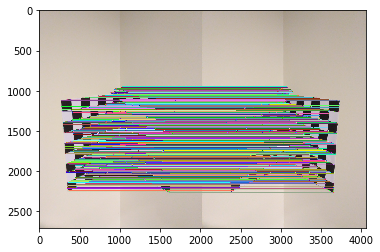

In [53]:
# Finds matching points in the two images using OpenCV's implementation of ORB.
# There can still be many spurious matches, though.

def hstack_images(imgA, imgB):
    """
    Stacks 2 images side-by-side
    :param imgA:
    :param imgB:
    :return:
    """
    Height = max(imgA.shape[0], imgB.shape[0])
    Width  = imgA.shape[1] + imgB.shape[1]

    newImg = np.zeros((Height, Width, 3), dtype=imgA.dtype)
    newImg[:imgA.shape[0], :imgA.shape[1], :] = imgA
    newImg[:imgB.shape[0], imgA.shape[1]:, :] = imgB

    return newImg

def draw_epipolar_lines(F, img_left, img_right, pts_left, pts_right):
    """
    Draw the epipolar lines given the fundamental matrix, left right images
    and left right datapoints
    You do not need to modify anything in this function, although you can if
    you want to.
    :param F: 3 x 3; fundamental matrix
    :param img_left:
    :param img_right:
    :param pts_left: N x 2
    :param pts_right: N x 2
    :return:
    """
    # lines in the RIGHT image
    # corner points
    p_ul = np.asarray([0, 0, 1])
    p_ur = np.asarray([img_right.shape[1], 0, 1])
    p_bl = np.asarray([0, img_right.shape[0], 1])
    p_br = np.asarray([img_right.shape[1], img_right.shape[0], 1])

    # left and right border lines
    l_l = np.cross(p_ul, p_bl)
    l_r = np.cross(p_ur, p_br)

    fig, ax = plt.subplots()
    ax.imshow(img_right)
    ax.autoscale(False)
    ax.scatter(pts_right[:, 0], pts_right[:, 1], marker='o', s=20, c='yellow',
        edgecolors='red')
    for p in pts_left:
        p = np.hstack((p, 1))[:, np.newaxis]
        l_e = np.dot(F, p).squeeze()  # epipolar line
        p_l = np.cross(l_e, l_l)
        p_r = np.cross(l_e, l_r)
        x = [p_l[0]/p_l[2], p_r[0]/p_r[2]]
        y = [p_l[1]/p_l[2], p_r[1]/p_r[2]]
        ax.plot(x, y, linewidth=1, c='blue')

    # lines in the LEFT image
    # corner points
    p_ul = np.asarray([0, 0, 1])
    p_ur = np.asarray([img_left.shape[1], 0, 1])
    p_bl = np.asarray([0, img_left.shape[0], 1])
    p_br = np.asarray([img_left.shape[1], img_left.shape[0], 1])

    # left and right border lines
    l_l = np.cross(p_ul, p_bl)
    l_r = np.cross(p_ur, p_br)

    fig, ax = plt.subplots()
    ax.imshow(img_left)
    ax.autoscale(False)
    ax.scatter(pts_left[:, 0], pts_left[:, 1], marker='o', s=20, c='yellow',
        edgecolors='red')
    for p in pts_right:
        p = np.hstack((p, 1))[:, np.newaxis]
        l_e = np.dot(F.T, p).squeeze()  # epipolar line
        p_l = np.cross(l_e, l_l)
        p_r = np.cross(l_e, l_r)
        x = [p_l[0]/p_l[2], p_r[0]/p_r[2]]
        y = [p_l[1]/p_l[2], p_r[1]/p_r[2]]
        ax.plot(x, y, linewidth=1, c='blue')

def get_matches(pic_a, pic_b, n_feat):
    orb = cv2.ORB_create(nfeatures=int(n_feat))
    kp_a, desc_a = orb.detectAndCompute(pic_a, None)
    kp_b, desc_b = orb.detectAndCompute(pic_b, None)
    dm = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = dm.knnMatch(desc_b, desc_a, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < n.distance/1.2:
            good_matches.append(m)
    pts_a = []
    pts_b = []
    for m in good_matches:
        pts_a.append(kp_a[m.trainIdx].pt)
        pts_b.append(kp_b[m.queryIdx].pt)
    return np.asarray(pts_a), np.asarray(pts_b)

def show_correspondence2(imgA, imgB, X1, Y1, X2, Y2, line_colors=None):
    """
    Visualizes corresponding points between two images. Corresponding points will
    have the same random color.
    :param imgA:
    :param imgB:
    :param x1:
    :param y1:
    :param x2:
    :param y2:
    :param line_colors: N x 3 colors of correspondence lines (optional)
    :return:
    """
    newImg = hstack_images(imgA, imgB)
    shiftX = imgA.shape[1]
    X1 = X1.astype(np.int)
    Y1 = Y1.astype(np.int)
    X2 = X2.astype(np.int)
    Y2 = Y2.astype(np.int)

    dot_colors = np.random.rand(len(X1), 3)
    if imgA.dtype == np.uint8:
        dot_colors *= 255
    if line_colors is None:
        line_colors = dot_colors

    for x1, y1, x2, y2, dot_color, line_color in zip(X1, Y1, X2, Y2, dot_colors,
            line_colors):
        newImg = cv2.circle(newImg, (x1, y1), 5, dot_color, -1)
        newImg = cv2.circle(newImg, (x2+shiftX, y2), 5, dot_color, -1)
        newImg = cv2.line(newImg, (x1, y1), (x2+shiftX, y2), line_color, 2,
                                            cv2.LINE_AA)
    return newImg

points_2d_pic_a, points_2d_pic_b = get_matches(pic_a, pic_b, n_feat)
print('Found {:d} possibly matching features'.format(len(points_2d_pic_a)))
match_image = show_correspondence2(pic_a, pic_b,
                                   points_2d_pic_a[:, 0], points_2d_pic_a[:, 1],
                                   points_2d_pic_b[:, 0], points_2d_pic_b[:, 1])
plt.figure(); plt.imshow(match_image)

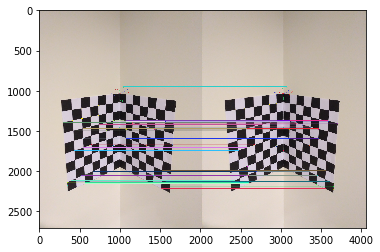

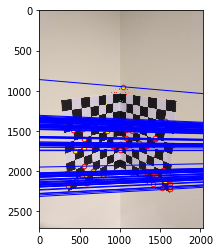

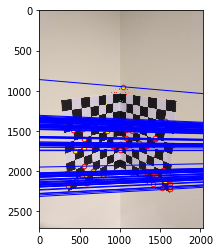

In [54]:


F, matched_points_a, matched_points_b= ransac_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)

# Draw the epipolar lines on the images and corresponding matches
match_image = show_correspondence2(pic_a, pic_b,
                                   matched_points_a[:, 0], matched_points_a[:, 1],
                                   matched_points_b[:, 0], matched_points_b[:, 1])

plt.figure(); plt.imshow(match_image)
draw_epipolar_lines(F, pic_a, pic_b, matched_points_a, matched_points_b)

In [55]:
print (" Ransac Fundamental Matrix ")
F


 Ransac Fundamental Matrix 
[[ 0.00000000e+00 -2.36699533e-07  4.12271055e-04]
 [ 2.36699533e-07 -1.37793873e-21 -2.43200361e-03]
 [-4.12271055e-04  2.43200361e-03 -1.33226763e-15]]


In [ ]:
print('Inliners')
print(matched_points_a, matched_points_b)